# Exploring COVID-19 Cases in the US
#### Author: Victor Cannestro

### Imports

In [1]:
import numpy as np
import pandas as pd
import missingno as msn

import geopandas
from shapely.geometry import Point

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import seaborn as sns
sns.set(font_scale=1.5) 

# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from bs4 import BeautifulSoup
import requests

# Code to center plots in the screen
from IPython.core.display import HTML 
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

### Imports for Testing

A note about style: I'll be using the optional [type annotations](https://docs.python.org/3/library/typing.html) feature of Python to make function inputs and return values more explicit. 

In [2]:
from typing import List, Optional

### Exploring the Time-Series

First, we import the county level time-series data gathered by the NY Times on Github (without downloading it) using `pd.read_csv()` and parse the retrieved data into an organized, multi-indexed `DataFrame`. The resulting DataFrame will be indexed by `state`, `county`, and `date` and have three columns: `fips`, `cases`, and `deaths`. Here, `fips` stands for the __F__ederal __I__nformation __P__rocessing __S__eries which are the codes most commonly used by the US Census Bureau. To download the data directly into the current working directory, instead, one could call 

```python
import urllib

url = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"
filename = 'myfilename.csv'
urllib.request.urlretrieve(url, filename)
```

#### Pandas reminders:
[read_csv()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html), [DataFrame()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), [MultiIndex](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html), [concat()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html#pandas.concat)

In [3]:
# URL to NY Times COVID-19 data
url = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv"

# Read the values, set the indices, parse the dates, and alphabetize
df = pd.read_csv(url, 
                 header=0, 
                 index_col=['state','county','date'], 
                 parse_dates=True).sort_index()

df.sample(5)

,,,fips,cases,deaths
state,county,date,,,
Maryland,Montgomery,2020-06-02,24031.0,11771,624
Texas,La Salle,2020-04-16,48283.0,1,0
Virginia,Wise,2020-04-07,51195.0,3,0
Louisiana,St. Tammany,2020-05-20,22103.0,1572,151
New York,Nassau,2020-05-01,36059.0,36161,2140


Before moving on with further processing let's check to see if there are any missing or suspect values (like negative cases or deaths) in the data and correct them.

In [4]:
neg_cases = df.cases.values[df.cases.values < 0]
assert set(neg_cases) == set(), 'FAILED: there is a negative value' 

In [5]:
assert len(df[df.cases.isna()]) == 0, 'FAILED: there is a nan value' 

In [6]:
neg_deaths = df.deaths.values[df.deaths.values < 0]
assert set(neg_deaths) == set(), 'FAILED: there is a negative value' 

In [7]:
assert len(df[df.deaths.isna()]) == 0, 'FAILED: there is a nan value' 

We can immediately see how easy is is to look up state and county level information using this indexing scheme. Moreover, because the index is sorted by date (which is a collection of `datetime` objects) as well as alphabetically by state and county we can easily isolate the time-series data for each county in preparation for further analysis, genreating choropleths, etc. For example, let's peak at the latest King County, WA data:

In [8]:
king = df.loc[('Washington','King')] # See the latest data for King County
king.tail()

,fips,cases,deaths
date,,,
2020-07-31,53033.0,15216,668
2020-08-01,53033.0,15418,674
2020-08-02,53033.0,15529,676
2020-08-03,53033.0,15653,677
2020-08-04,53033.0,15798,678


Notice how the `cases` and `deaths` columns are expressed as the running aggregate values instead of new reported cases and deaths. Let's write a function that will accept the DataFrame and columns we're interested in and compute the difference between consecutive days.

In [9]:
def dailyChanges(dataframe: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    '''
    Args:  
        dataframe (pandas DataFrame): the input dataframe of cumulative updates. 
                                      Must be single indexed.
        cols (list): list of column labels
        
    Returns:       
        changes (pandas DataFrame): quantizing the difference between daily values as the 
                                    number of new cases per day. The values should be non-
                                    negative integers and have the same shape as dataframe.
    
    Notes: Calculates array subtraction for each date in the Time Series 
           i.e.
    
           changes = df_today_values - df_yesterday_values
           
           This method utilizes the underlying numpy arrays so no for-loops are needed.
           The old method was based on elementwise subtraction via for-loop iteration:
           
           new  = [dataframe[cols].iloc[0]]
    
           # Loop over each date and take the differences
           for i in range(1, len(dataframe)):
               new.append(dataframe[cols].iloc[i] - dataframe[cols].iloc[i-1])

           # Convert new into a DataFrame the same indices as dataframe
           new_df = pd.DataFrame(data=new, index=dataframe.index)
           
    '''
    today = dataframe[cols]
    
    # 1xlen(cols) pad of zeros for first element
    pad = pd.DataFrame({k:0 for k in cols}, index=[dataframe.index[0]]) 

    # Drop the last row this means the DF stops at second to latest date
    yesterday = today.drop(today.index[-1]) 
    
    # Relabel the index so every value is dated one day ahead (needed for the subtraction later)
    yesterday.index = today.index[1:]

    # glue the zero pad to temp
    yesterday = pd.concat((pad, yesterday)) 

    # Element wise calculation of the daily changes (dates need to match up)
    changes = today - yesterday
    
    # Edit the column names to reflect the daily changes
    changes.columns = ['new_' + name for name in cols]
    
    return changes

In [10]:
daily_king = dailyChanges(df.loc[('Washington','King')], ['cases','deaths']).apply(abs)
daily_king.tail()

,new_cases,new_deaths
date,,
2020-07-31,158,0
2020-08-01,202,6
2020-08-02,111,2
2020-08-03,124,1
2020-08-04,145,1


The summary statistics of these daily change columns provide us with some broad insights about how King County is being affected:
  
- `max` 
   - The most reported new cases $\approx 269$
   - The most reported new deaths $\approx 19$
   
- $\dots$

In [11]:
daily_king.describe()

,new_cases,new_deaths
count,159.000000,159.000000
mean,99.811321,4.352201
std,62.628922,3.990714
min,0.000000,0.000000
25%,50.000000,1.000000
50%,93.000000,3.000000
75%,145.000000,6.000000
max,269.000000,19.000000


To smooth out any extreme changes we'll also implement a rolling $N$-day average function using the built-in solution offered by `pandas`: [`DataFrame.rolling()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html)

In [12]:
def smoother(dataframe: pd.DataFrame, cols: List[str], N: int =7) -> pd.DataFrame:
    '''
    Args:  
    
        dataframe (pandas DataFrame): the input dataframe of cumulative updates
        cols (list): column labels
        N (int >= 0): number of days to average
        
    Returns: 
    
        new (pandas DataFrame): smoothed N-day rolling average where the first N
                                entries are the same as dataframe. Columns are
                                renamed with 'average_' appending to beginning.
    
    Notes:
    
        The old method used for-loop iteration and a generator expression
        for readibility and to save memory but wasn't a great implementation:
        https://www.python.org/dev/peps/pep-0289/
        
        new  = []  
        # Loop over each date and take the differences
        for i in range(N, len(dataframe)):       
            # Generator expression to compute the sum
            ave = sum(dataframe[cols].iloc[i-k] for k in [*range(N)]) / N
            new.append(ave)
            
        # Get the indices of the data after the initial N-days and make DataFrame
        idx = dataframe.index[N: len(dataframe)]
        calc = pd.DataFrame(data=new, index=idx)
        
        # Append the averaged data to the initial N-days
        temp = dataframe[cols].iloc[:N].append(calc)
        
    '''
    # Calculate the rolling N-day average
    calc = dataframe.rolling(N).mean()
    
    # Append the averaged data to the initial N-days
    average = dataframe[cols].iloc[:N].append(calc.iloc[N:])
    
    # Edit the column name(s) in temp to include 'average'
    average.columns = ['average_' + name for name in cols]
    
    return average

In [13]:
smoothed = smoother(daily_king, daily_king.columns, 7)

Excellent, now we can use the information within `king` to make a variety of graphs ([bar](https://matplotlib.org/3.3.0/api/_as_gen/matplotlib.pyplot.bar.html), [step](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.step.html), [etc](https://matplotlib.org/3.1.0/gallery/color/named_colors.html).) to better understand the dynamics of the virus over time and spot any trends that may appear. To make the [dates on the x-axis look more appealing](https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/customize-dates-matplotlib-plots-python/) we will use the `DateFormatter` module from `matplotlib` to customize the display format: `"%X %X"` where each `%X`  represents:

Syntax | Meaning | Example: (July 2020)
---|---|---
`%Y` | 4 digit year | 2020
`%y` | 2 digit year | 20
`%m` | month as a number | 07
`%b` | month as abbreviated name | Jul


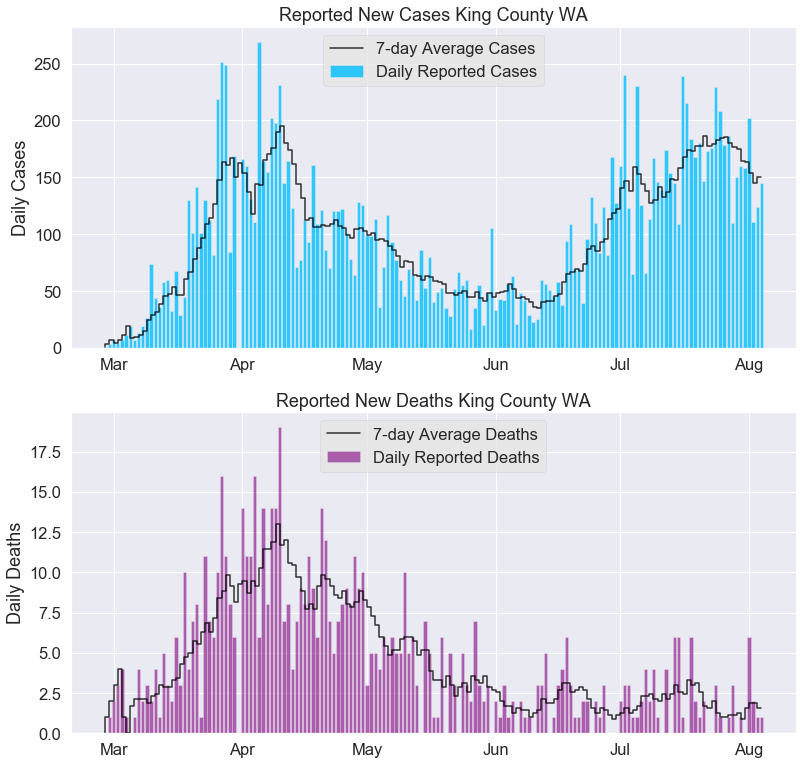

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(13,13))

plt.style.use('ggplot')

# Plot the new reported cases
ax[0].bar(daily_king.index, 
           daily_king.new_cases,  
           color='deepskyblue',
           label='Daily Reported Cases',
           alpha=0.8)

ax[0].step(smoothed.index, 
           smoothed.average_new_cases, 
           color='black',
           alpha=0.8,
           label='7-day Average Cases')

# Plot the new reported deaths
ax[1].bar(daily_king.index, 
           daily_king.new_deaths, 
           color='purple',
           label='Daily Reported Deaths',
           alpha=0.6)

ax[1].step(smoothed.index, 
           smoothed.average_new_deaths, 
           color='black',
           alpha=0.8,
           label='7-day Average Deaths')

# Set axis labels and titles
ax[0].set_title('Reported New Cases King County WA', fontsize=18)
ax[0].set_ylabel('Daily Cases', fontsize=18)
ax[1].set_title('Reported New Deaths King County WA', fontsize=18)
ax[1].set_ylabel('Daily Deaths', fontsize=18)

# Format the dates displayed on the xaxis
date_form = DateFormatter("%b")
ax[0].xaxis.set_major_formatter(date_form)
ax[1].xaxis.set_major_formatter(date_form)

# Show the legend and plots
ax[0].legend()
ax[1].legend(loc='upper center')

plt.savefig('figures/Daily_King_County')
plt.show()

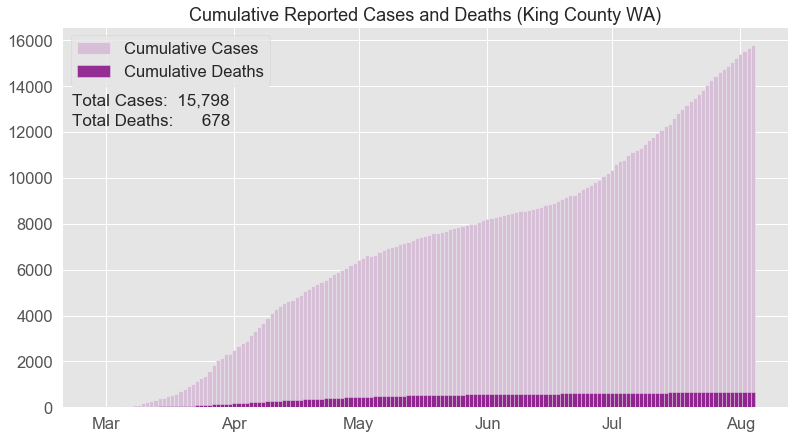

In [68]:
fig, ax = plt.subplots(figsize=(13,7))

plt.style.use('ggplot')

ax.bar(king.index,
       king.cases,
       color='thistle',
       label='Cumulative Cases',
       width=1)

ax.bar(king.index,
       king.deaths,
       color='purple',
       label='Cumulative Deaths',
       width=1,
       alpha=0.8)

ax.set_title('Cumulative Reported Cases and Deaths (King County WA)', fontsize=18)

# Annotate with the total number of cases and deaths.
ax.annotate('Total Cases:  {:,}'.format(king.cases.values[-1]), (10,302), fontsize=17, xycoords='axes pixels')
ax.annotate('Total Deaths:      {:,}'.format(king.deaths.values[-1]), (10,282), fontsize=17, xycoords='axes pixels')

date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)

plt.legend()
plt.savefig('figures/Cumulative_King_County')
plt.show()

### COVID-19 by US Regions

Now we'll filter `df` by regions of the US, however, it's somewhat tedious to keep this record using the full state names. As such, we'll manually add the appropriate postal code labels to a list. Next, we'll grab a mapping of the postal codes and state names from a table made available by the [Natural Resources Conservation Service (NRCS)](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013696) using [`BeautifulSoup`](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) and the `requests` module. Finally, we'll [merge](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html) the postal codes to `df`. Note that the `fips` columns in the two DataFrames differ. The `fips` codes given by the NRCS are directly compatible with the `.geojson` file we'll be using to make the maps.

In [16]:
# Lists of the regions of the US
northeast = ['CT', 'DE', 'ME', 'MD', 'MA', 'NH', 'NJ', 'NY', 'PA', 'RI', 'VT']
midwest = ['IL', 'IN', 'IA', 'KA', 'MI', 'MO', 'MN', 'NE', 'ND', 'OH', 'SD', 'WI']
south = ['AL', 'AR', 'FL', 'GA', 'KY', 'LA', 'MS', 'NC', 'OK', 'SC', 'TN', 'TX', 'VA', 'WV']
west = ['AK', 'AZ', 'CA', 'CO', 'HI', 'ID', 'MT', 'NV', 'NM', 'OR', 'UR', 'WA', 'WY']

In [17]:
url = "https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013696"
html_content = requests.get(url).text      # Make a GET request to fetch the raw HTML content
soup = BeautifulSoup(html_content, "lxml") # Parse the html content

fips, countyName, stateName = [], [], []
for tr in soup.find_all('tr')[29:-6]: #Found bounds manually
    tds = tr.find_all('td')
    fips.append(tds[0].text.replace('\r\n\t\t\t\t',''))
    countyName.append(tds[1].text.replace('\r\n\t\t\t\t',''))
    stateName.append(tds[2].text.replace('\r\n\t\t\t\t',''))

statefips = pd.DataFrame()
statefips['name'] = fips
statefips['postal code'] = countyName
statefips['fips'] = stateName
statefips.head()

,name,postal code,fips
0,Alabama,AL,01
1,Alaska,AK,02
2,Arizona,AZ,04
3,Arkansas,AR,05
4,California,CA,06


In [18]:
# Reset the index to default
data = df.reset_index()

# Drop the old fips column and merge with the statefips DataFrame on most similar column
data = data.drop('fips', axis=1).merge(statefips, left_on='state', right_on='name', how='inner')

# Drop the redundant name and state columns and index by date
data = data.drop(['name','state'], axis=1).set_index('date').sort_values('date')
data.head()

,county,cases,deaths,postal code,fips
date,,,,,
2020-01-21,Snohomish,1,0,WA,53
2020-01-22,Snohomish,1,0,WA,53
2020-01-23,Snohomish,1,0,WA,53
2020-01-24,Snohomish,1,0,WA,53
2020-01-24,Cook,1,0,IL,17


Now we're ready to subset `data` by regions. Notice that `data`, and therefore `NE`,`S`,`MW`,`W`, have multiple entries for any single date, because the virus spread to multiple locations as time went on. We'll need to aggregate those entries into a single instance of that date describing the number of cases for the entire region on that day before passing it to `dailyChanges()`.

In [19]:
NE = data[data['postal code'].isin(northeast)]
S = data.loc[data['postal code'].isin(south)]
MW  = data.loc[data['postal code'].isin(midwest)]
W = data.loc[data['postal code'].isin(west)]

In [20]:
def sumByDate(dataframe: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    '''
    Args:
        dataframe (DataFrame): A dataframe with multiple entries for 
                               any single date. Must be indexed by date.
        cols (list): list of columns to consider
        
    Returns:
        aggDF (DataFrame): A dataframe with a single entry for any
                           single date, aggregated by sum
        
    Notes:
    '''
    # Get the unique dates
    idx = dataframe.index.unique()
    sumDF = pd.DataFrame(index=idx, columns=cols)
    for date in idx:
        # aggregate by sum on a single date
        sumDF.loc[date] = dataframe[cols].loc[date].sum()
    return sumDF

In [21]:
# Aggregate the multiple cases on any one date
sum_NE = sumByDate(NE, ['cases','deaths'])
sum_S = sumByDate(S, ['cases','deaths'])
sum_MW = sumByDate(MW, ['cases','deaths'])
sum_W = sumByDate(W, ['cases','deaths'])

In [22]:
# Find the newly reported daily cases 
dailyNE = dailyChanges(sum_NE, ['cases','deaths'])
dailyS = dailyChanges(sum_S, ['cases','deaths'])
dailyMW = dailyChanges(sum_MW, ['cases','deaths'])
dailyW = dailyChanges(sum_W, ['cases','deaths'])

The . We'll also add an [annotation](https://matplotlib.org/3.3.0/api/_as_gen/matplotlib.pyplot.annotate.html) describing the percentage of the regional population that's been reported as infected with COVID-19 using regional population data from the  [US Census Bureau](https://www.census.gov/popclock/print.php?component=growth&image=//www.census.gov/popclock/share/images/growth_1561939200.png). 

In [60]:
# Populations as of the 2019 Census
popNE, popS, popMW, popW = 55982803, 68329004, 78347268, 125580448

# Number of total cases per region 
casesW, casesMW, casesNE, casesS = dailyW.sum()[0], dailyMW.sum()[0], dailyNE.sum()[0], dailyS.sum()[0]

# Number of total deaths per region 
deathsW, deathsMW, deathsNE, deathsS = dailyW.sum()[1], dailyMW.sum()[1], dailyNE.sum()[1], dailyS.sum()[1]

# Percent of regional population infected
percentW = (casesW / popW) * 100
percentMW = (casesMW / popMW) * 100
percentNE = (casesNE / popNE) * 100
percentS = (casesS / popS) * 100

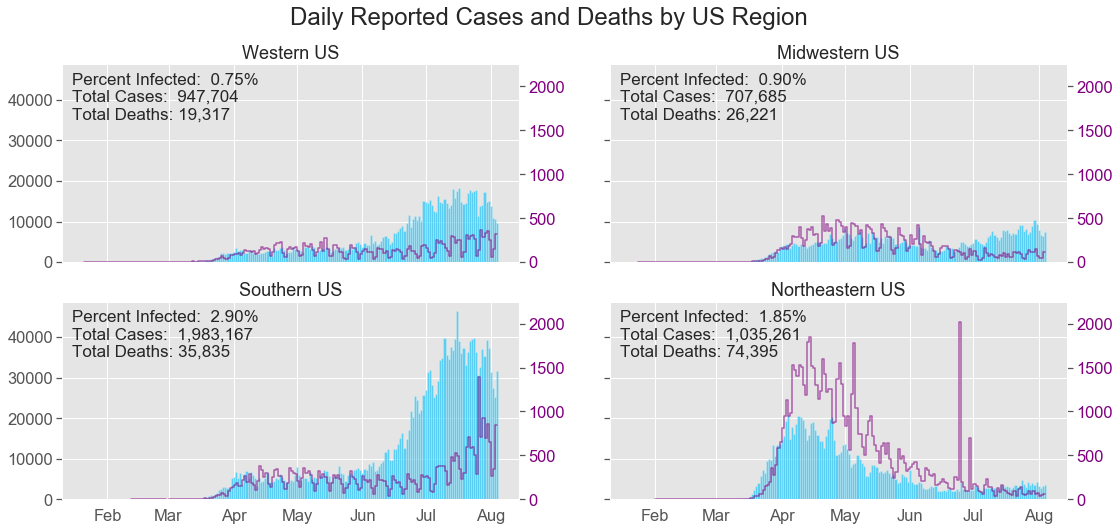

In [64]:
fig, ax = plt.subplots(2,2, sharey=True, sharex=True, figsize=(18,8))

plt.style.use('ggplot')

# Format the dates displayed on the xaxis
date_form = DateFormatter("%b")

# Set overall title
fig.suptitle('Daily Reported Cases and Deaths by US Region', fontsize=24)

# Tuples of Cases, deaths, and percentages of population for later annotations
numbers = [(percentW, int(casesW), int(deathsW)),
           (percentMW, int(casesMW), int(deathsMW)),
           (percentNE, int(casesNE), int(deathsNE)),
           (percentS, int(casesS), int(deathsS))]

titles = ['Western US', 'Midwestern US', 'Northeastern US', 'Southern US']

# Will effectively become [axW, axMW, axNE, axS]
new_axes = []

# Set plot parameters in a relatively efficient manner
for i, axis in enumerate([ax[0,0], ax[0,1], ax[1,1], ax[1,0]]):
    # Set titles
    axis.set_title(titles[i], fontsize=18)
    
    # Format the dates displayed on the xaxis
    axis.xaxis.set_major_formatter(date_form)
    
    # Annotate with the total number of cases and deaths.
    axis.annotate('Percent Infected:  {:.2f}%\nTotal Cases:  {:,}\nTotal Deaths: {:,}'.format(*numbers[i]), 
                  (10,143), 
                  fontsize=17, 
                  xycoords='axes pixels')
    
    # Make dual axes
    new_axes.append(axis.twinx())

# Modify the dual axes xlabels and make the tick labels the color of the deaths graphs
for axis in new_axes:
    axis.tick_params(axis='y', labelcolor='purple')
    axis.xaxis.set_major_formatter(date_form)
    axis.set_ylim([0,2250])
    axis.grid(False)

# Plot the West
ax[0,0].bar(dailyW.index, 
            dailyW.new_cases, 
            width=1,
            color='deepskyblue',
            label='Western',
            alpha=0.6)
new_axes[0].step(dailyW.index, 
                 dailyW.new_deaths,  
                 color='purple',
                 label='Daily Deaths',
                 alpha=0.6)

# Plot the Midwest
ax[0,1].bar(dailyMW.index, 
            dailyMW.new_cases,  
            color='deepskyblue',
            width=1,
            label='Midwestern',
            alpha=0.6)
new_axes[1].step(dailyMW.index, 
                 dailyMW.new_deaths,  
                 color='purple',
                 label='Daily Deaths',
                 alpha=0.6)

# Plot the Northeast
ax[1,1].bar(dailyNE.index, 
            dailyNE.new_cases,  
            color='deepskyblue',
            width=1,
            label='Northeastern',
            alpha=0.6)
new_axes[2].step(dailyNE.index, 
                 dailyNE.new_deaths,  
                 color='purple',
                 label='Daily Deaths',
                 alpha=0.6)

# Plot the South
ax[1,0].bar(dailyS.index, 
            dailyS.new_cases,  
            color='deepskyblue',
            width=1,
            label='Southern',
            alpha=0.6)
new_axes[3].step(dailyS.index, 
                 dailyS.new_deaths,  
                 color='purple',
                 label='Daily Deaths',
                 alpha=0.6)

plt.savefig('figures/Daily_US_Regions')
plt.show()

### COVID-19 in the US as a Whole
Rather than aggregating `cases` and `deaths` by `datatime` instance to get the total daily reported cases and deaths in the US, let's import a dataset that already has that information and produce a bar graph.

In [25]:
# URL to NY Times COVID-19 data
url = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv"

# Read the values, set the indices, parse the dates, and alphabetize
usa = pd.read_csv(url, 
                  header=0, 
                  index_col=['date'], 
                  parse_dates=True).sort_index()
usa.tail(3)

,cases,deaths
date,,
2020-08-02,4677855,155336
2020-08-03,4725274,155941
2020-08-04,4778669,157299


In [26]:
usa_daily = dailyChanges(usa, ['cases','deaths'])
usa_daily.tail(3)

,new_cases,new_deaths
date,,
2020-08-02,49321,418
2020-08-03,47419,605
2020-08-04,53395,1358


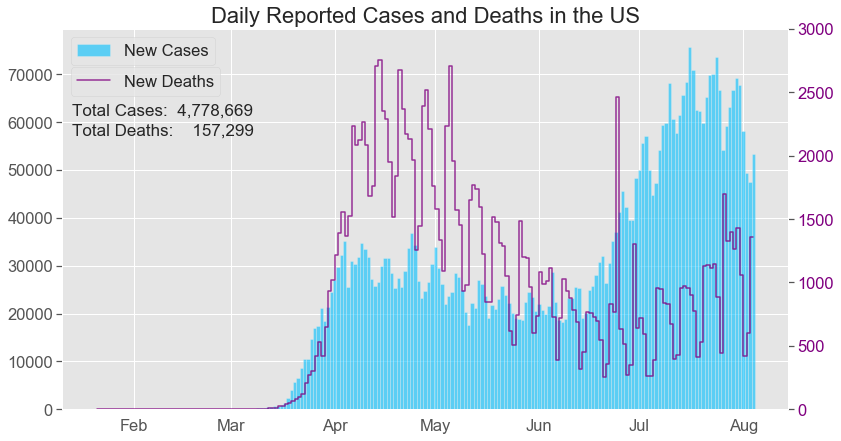

In [50]:
fig, ax = plt.subplots(figsize=(13,7))

plt.style.use('ggplot')

# Let the deaths be described by another pair of axis for enlargement
ax2 = ax.twinx()

# Plot the new US cases
ax.bar(usa_daily.index,
       usa_daily.new_cases,
       color='deepskyblue',
       label='New Cases',
       width=1,
       alpha=0.6)

# Plot the new US deaths
ax2.step(usa_daily.index,
         usa_daily.new_deaths,
         color='purple',
         label='New Deaths',
         alpha=0.8)

ax.set_title('Daily Reported Cases and Deaths in the US', fontsize=22)

# Annotate with the total number of cases and deaths. 
ax.annotate('Total Cases:  {:,}'.format(usa.cases.values[-1]), (10,294), fontsize=17, xycoords='axes pixels')
ax.annotate('Total Deaths:    {:,}'.format(usa.deaths.values[-1]), (10,274), fontsize=17, xycoords='axes pixels')

# Formate the x-axis dates
date_form = DateFormatter("%b")
ax.xaxis.set_major_formatter(date_form)

# Make ax2 tick labels the color of the graph
ax2.tick_params(axis='y', labelcolor='purple')
ax2.set_ylim([0,3000])

# Format the legend and grid
ax.legend(loc='upper left')
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0.92))
ax2.grid(False)

# Save the figure
plt.savefig('figures/Daily_US')
plt.show()

## __Action item:__ 
investigate the `'Unknown'` county reported and drop it if necessary

In [28]:
df.index.get_level_values(0).unique()

Index(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia',
       'Guam', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas',
       'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts',
       'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana',
       'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico',
       'New York', 'North Carolina', 'North Dakota',
       'Northern Mariana Islands', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virgin Islands', 'Virginia', 'Washington', 'West Virginia',
       'Wisconsin', 'Wyoming'],
      dtype='object', name='state')

In [29]:
# Now let's see how we can get the county information
df.loc[('Washington')].index.get_level_values(0).unique() 

Index(['Adams', 'Asotin', 'Benton', 'Chelan', 'Clallam', 'Clark', 'Columbia',
       'Cowlitz', 'Douglas', 'Ferry', 'Franklin', 'Garfield', 'Grant',
       'Grays Harbor', 'Island', 'Jefferson', 'King', 'Kitsap', 'Kittitas',
       'Klickitat', 'Lewis', 'Lincoln', 'Mason', 'Okanogan', 'Pacific',
       'Pend Oreille', 'Pierce', 'San Juan', 'Skagit', 'Skamania', 'Snohomish',
       'Spokane', 'Stevens', 'Thurston', 'Unknown', 'Wahkiakum', 'Walla Walla',
       'Whatcom', 'Whitman', 'Yakima'],
      dtype='object', name='county')

### Underlying US County and State Boundary Maps

The data was obtained through the the US Census Bereau, which provided the `.shp` files of the boudary data. An [online file conversion tool](https://mygeodata.cloud/converter/) was then used to generate `geojson` files from the raw boundary data. 

- https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
- https://eric.clst.org/tech/usgeojson/

- https://github.com/johan/world.geo.json/tree/master/countries/USA


- [State FIPS Codes](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013696)
- [County FIPS Codes](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697)

In [85]:
# Getting to know GEOJSON file:
counties = geopandas.read_file("data/cb_2018_us_county_20m.geojson")
print(type(counties))
counties.sort_values(by=['STATEFP','NAME']).head()

<class 'geopandas.geodataframe.GeoDataFrame'>


,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
492,01,001,00161526,0500000US01001,01001,Autauga,06,1539602123,25706961,"POLYGON ((-86.91760 32.66417, -86.71339 32.661..."
2009,01,003,00161527,0500000US01003,01003,Baldwin,06,4117546676,1133055836,"POLYGON ((-88.02632 30.75336, -87.94455 30.827..."
2428,01,005,00161528,0500000US01005,01005,Barbour,06,2292144655,50538698,"POLYGON ((-85.73573 31.62449, -85.66565 31.786..."
620,01,007,00161529,0500000US01007,01007,Bibb,06,1612167481,9602089,"POLYGON ((-87.42194 33.00338, -87.31854 33.006..."
1155,01,009,00161530,0500000US01009,01009,Blount,06,1670103911,15015423,"POLYGON ((-86.96336 33.85822, -86.92439 33.909..."


In [31]:
# Merge with the statefips DataFrame on state and name and drop redundant colum
#df = df.reset_index().merge(statefips, left_on='state', right_on='name', how='inner').drop(['name','state','fips_x'], axis=1)

# Merge with the statefips DataFrame on most similar column
#data = df.merge(statefips, left_on='fips_y', right_on='fips', how='inner')

# Drop the redundant columns and index by postal code, county, date
#data = data.drop(['name','fips_y','postal code_y'], axis=1).set_index(['postal code_x','county','date']).sort_values('date')

In [77]:
# Merge with the statefips DataFrame on state and name and drop redundant columns
counties = statefips.merge(county, left_on='fips', right_on='STATEFP', how='inner').drop(['name', 'fips'], axis=1)
print(len(counties))
print(type(counties))
county.sort_values(by=['STATEFP','NAME']).head()

3219


,postal code,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
12,AL,01,001,00161526,0500000US01001,01001,Autauga,06,1539602123,25706961,"POLYGON ((-86.91760 32.66417, -86.71339 32.661..."
42,AL,01,003,00161527,0500000US01003,01003,Baldwin,06,4117546676,1133055836,"POLYGON ((-88.02632 30.75336, -87.94455 30.827..."
50,AL,01,005,00161528,0500000US01005,01005,Barbour,06,2292144655,50538698,"POLYGON ((-85.73573 31.62449, -85.66565 31.786..."
14,AL,01,007,00161529,0500000US01007,01007,Bibb,06,1612167481,9602089,"POLYGON ((-87.42194 33.00338, -87.31854 33.006..."
21,AL,01,009,00161530,0500000US01009,01009,Blount,06,1670103911,15015423,"POLYGON ((-86.96336 33.85822, -86.92439 33.909..."


In [41]:
#data.loc[('WA')]

## __Action item:__ 
merge `STATEFP` and `postal code` to make it easier to read

## __Action item:__ 
filter by postal codes instead of fips for same reason

In [86]:
# Exclude Alaska, Hawaii, American Samoa, Guam, Northern Mariana Islands, Puerto Rico, and the Virgin Islands for now
states = counties[counties['STATEFP'].isin(['02','15','60','66','69','72','78']) == False]

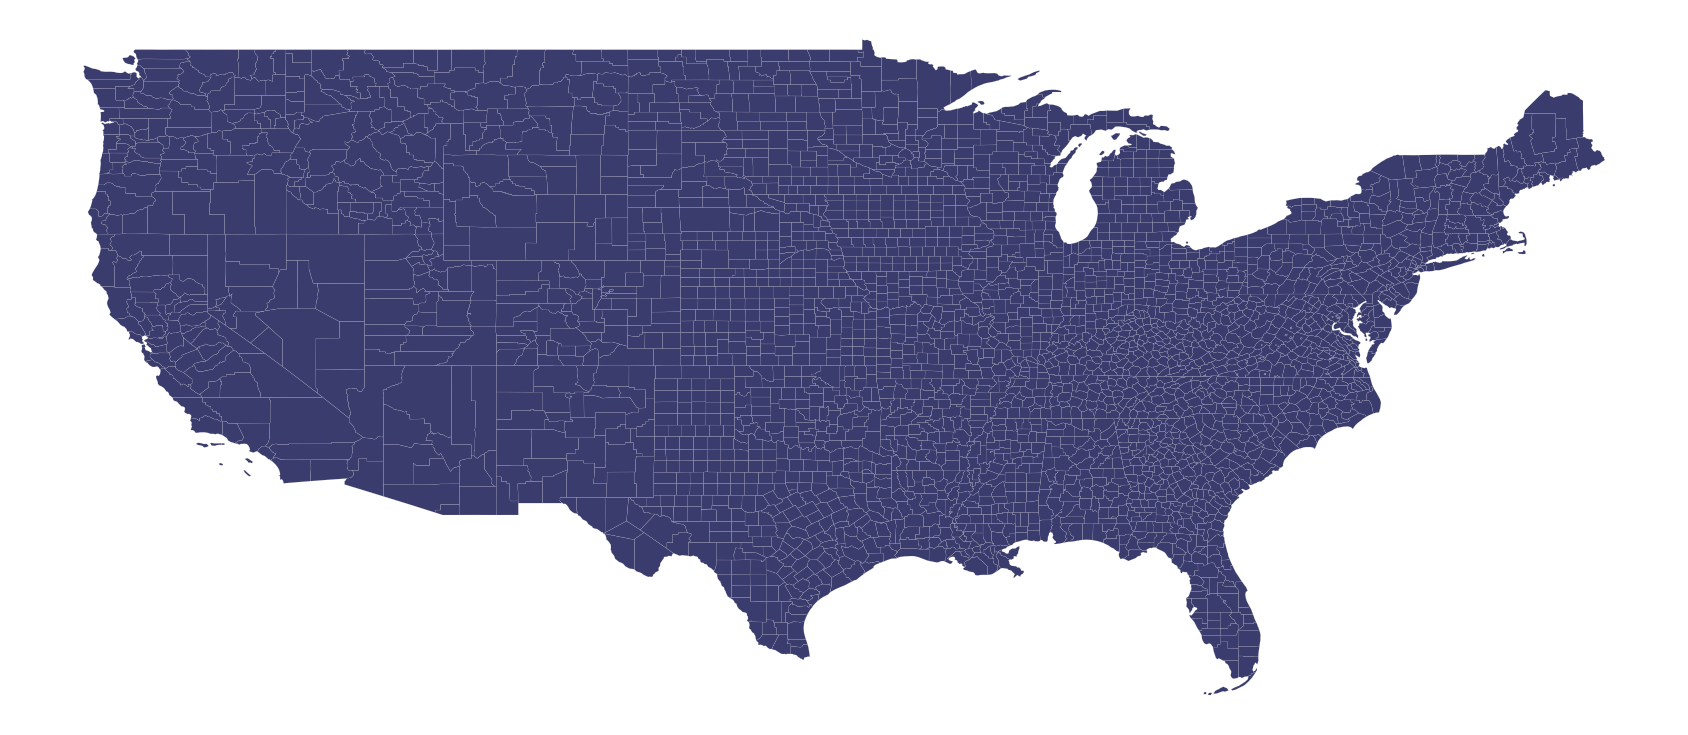

In [87]:
states.plot(figsize=(30,20), 
            color='#3B3C6E',
            linewidth=0.1)

plt.axis('off')
plt.show()

C:\Users\victo\anaconda3\lib\site-packages\geopandas\plotting.py:532: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


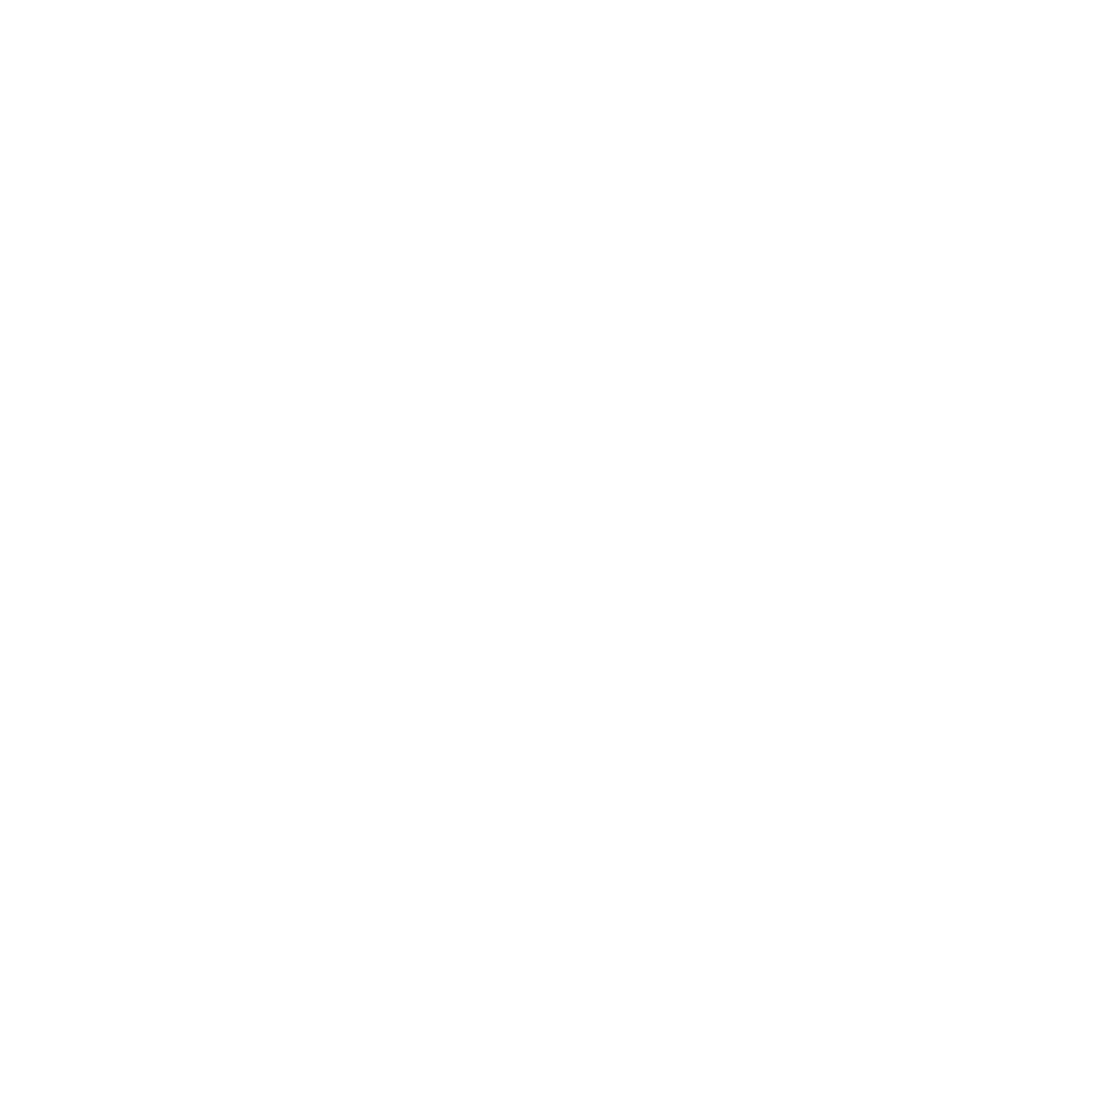

In [70]:
# County map of Washington State
WA = county[county['STATEFP'].isin(northeast) == True]

WA.plot(figsize=(30,20), color='#3B3C6E')
plt.axis('off')
plt.show()

### Making the Choropleths

"When making choropleths, it is important to always use a variable that is normalized for the area being plotted. Further, by using a classification scheme instead of a continuous color scale, we can make the map more easily interpretable."

To make the [choropleth map](https://geopandas.readthedocs.io/en/latest/mapping.html) I’ll need to do something like:

`covid19_county_data.plot(column=’cases’, scheme=quantile, k=12, cmap=’Purples’)`

- The color scheme is a graduated sequential scheme
    - I.e. `categorical=False`


__Action item:__ create a function that takes a geopandas DF and loops through each date and creates a choropleth based on the number of cases/100k

In [69]:
merged = pd.merge_ordered(WA, new, how='left', on='NAME').fillna(0)
    
merged.plot()#column='new cases', cmap='BuGn', edgecolor='black') 
    
plt.title('New COVID-19 cases on ')
plt.axis('off')
#plt.savefig('figs/New COVID-19 cases on '+str(d)[:10]);
plt.show()

KeyError: 'Washington'

### Animation

- Make animation of new cases vs time


- Number of total infections vs time